In [1]:
import re
import pandas as pd
pd.options.mode.chained_assignment = None
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
import string
from datetime import datetime
from utils.database_util import DatabaseUtil
from matplotlib import pyplot as plt
import seaborn as sns
import quandl
from sklearn import preprocessing
%matplotlib inline
pd.options.display.float_format = '{:,.0f}'.format

# Data Cleaning

In [2]:
# connect to the sqlite3 db file, utilizing the customized module
DBUtil = DatabaseUtil()
conn = DBUtil.get_conn()

* clean tweets data

In [3]:
df_t = pd.read_sql('select * from tweets', conn)

In [4]:
# tweets df before cleaning
df_t.sample(5)

,id,author,tweet,time,type
24800,1115274164330475522,CREA_ACI,@KeenerRemax Thanks for joining us at #CREAAGM!,2019-04-08 15:24:16,realtor
31534,1126117668640251906,MarketWatch,Stocks extend losses as U.S.-China trade spat ...,2019-05-08 13:32:29,biznews
29391,1124765898311708673,BNNBloomberg,'Not the right time' to take canola dispute to...,2019-05-04 20:01:01,biznews
39533,1128378961304653825,TheEconomist,Brexit is unlikely to make measurable progress...,2019-05-14 19:18:03,biznews
3220,740895124813549570,HOMESPublishing,https://t.co/2hify0AYty,2016-06-09 13:15:37,realtor


In [5]:
# twitter text processing and cleaning function
def process_words(raw, remove_punc=False, stem=False):
    link_pattern = [
        r'(http|https)://[a-zA-Z0-9\./]*\s',
        r'\s+(http|https)://[a-zA-Z0-9\./]*\s',
        r'\s+(http|https)://[a-zA-Z0-9\./]*$',
    ]
    clean = raw.lower().strip()
    for ptn in link_pattern:
        clean = re.sub(ptn, '', clean)
    if remove_punc:
        nopunc = [c for c in clean if c not in string.punctuation]
        raw = ''.join(nopunc)

    stopwords_list = []
    stopwords_list_en = set(stopwords.words('english'))
    stopwords_list_fr = set(stopwords.words('french'))
    stopwords_list.extend(stopwords_list_en)
    stopwords_list.extend(stopwords_list_fr)
   
    nostop = [w for w in raw.split() if w.lower() not in stopwords_list]
    if stem:
        stemmer = PorterStemmer()
        return ' '.join([stemmer.stem(t) for t in nostop])
    else:
        return ' '.join(nostop)

In [6]:
df_t['tweet_clean'] = df_t['tweet'].apply(lambda t: process_words(t, remove_punc=True))
# transform tweet timestamp from string format to datetime
df_t['date'] = df_t['time'].apply(lambda t: re.findall('\d\d\d\d-\d\d-\d\d',t)[0])
df_t['date'] = df_t['date'].apply(lambda s: datetime.strptime(s,'%Y-%m-%d'))
df_t.drop(['time','tweet'],axis = 1, inplace=True)

In [7]:
# tweets df after cleaning
df_t.sample(5)

,id,author,type,tweet_clean,date
10944,994565284857032704,BuzzBuzzHome,realtor,9 selfcare tips make home stressfree zone home...,2018-05-10
39016,1128315283322568706,zerohedge,biznews,burnout nation,2019-05-14
25259,1116276343497355265,globebusiness,biznews,subscribers thursday’s insider report three st...,2019-04-11
28051,1123198808169549824,BNNBloomberg,biznews,china sentences second canadian death drug cha...,2019-04-30
34023,1126893018773114886,DacostaJohn,search,toronto’s housing market entered busy spring p...,2019-05-10


In [8]:
# subsetting the dataframe, grouping by tweets categories
news = df_t[df_t['type'] == 'biznews']
realtor = df_t[df_t['type'] == 'realtor']
searched = df_t[df_t['type'] == 'search']

* clean web data

In [9]:
df_praw = pd.read_sql('select * from realmaster', conn)

In [10]:
# web df before cleaning
df_praw.sample(5)

,listID,address,ask,city,proptype
987,N4446199,326 John St Markham Ontario L3T0B1,649000,Markham,Townhouse
2798,W4442327,136 Cabana Dr Toronto Ontario M9L 1K9,729000,Toronto,Semi-Detached
335,30728423,111 1830 Walkers Line Burlington Ontario L7...,429990,Burlington,Apartment
2081,30722933,41 NORTH FORSTER PARK Drive Oakville Ontario L...,1225000,Oakville,Bungalow
1526,W4448516,7430 Copenhagen Rd Mississauga Ontario L5N2C4,549800,Mississauga,Townhouse


In [11]:
def get_postal(s):
    p = re.findall('[A-Z]\d[A-Z]\s?\d[A-Z]\d',s)
    if len(p) > 0:
        return p[0].replace(' ','')
    else:
        return None

In [12]:
df_p = df_praw.copy()

In [13]:
# spin out postal code
df_p['postal'] = df_p['address'].apply(lambda a: get_postal(a))

In [14]:
# clean city name ('Richmond%20Hill')
df_p['city'] = df_p['city'].apply(lambda c:c.replace('%20',' '))

In [15]:
# spin street address out of original raw format
def spin_address(df,col1,col2):
    df['bind'] = df[[col1,col2]].apply(tuple,axis=1)
    df['street'] = df['bind'].apply(lambda t: t[0].split(t[1])[0])
    new_df = df[['listID','proptype','ask','street','city','postal']]
    return new_df

In [16]:
df_p = spin_address(df_p,'address','city')

In [17]:
# web df after cleaning
df_p.sample(5)

,listID,proptype,ask,street,city,postal
3361,N4427621,Apartment,779000,7250 Yonge St,Vaughan,L4J7X1
1565,W4433691,Bungalow,1149900,3338 Riverspray Cres,Mississauga,L4Y3M4
515,X4072469,Detached,1499000,1079 #8 Highway,Hamilton,L9H5E1
3367,N4448616,Apartment,465000,9085 Jane St,Vaughan,None
3338,N4450685,Detached,1199000,107 Hudson Dr,Vaughan,L6A1X4


# Exploratory Analysis

## Sentiment

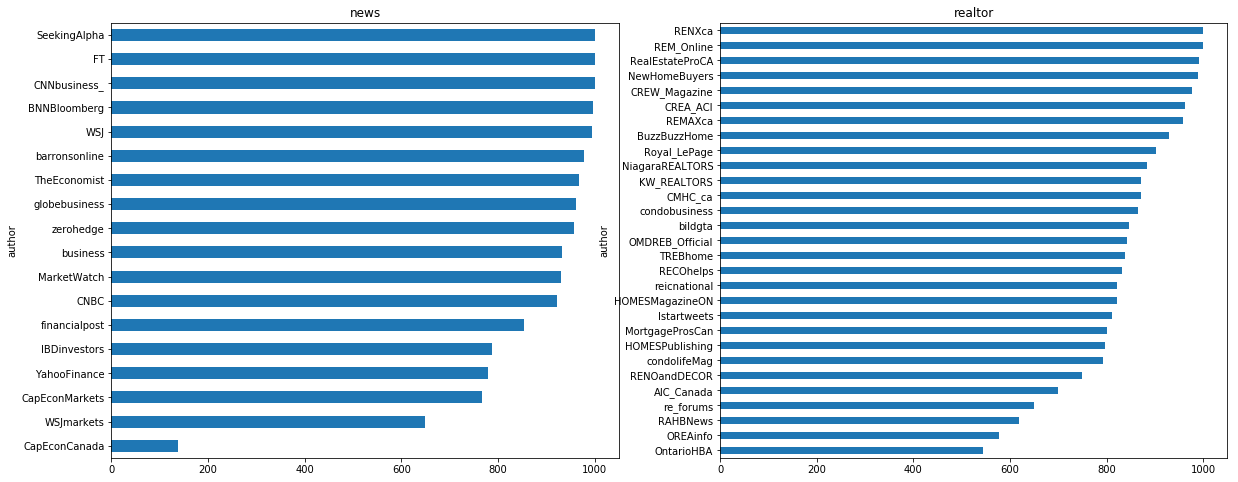

In [19]:
# count the number of tweets collected from each news outlet
cntfig = plt.figure(figsize=(20,8))
f1 = cntfig.add_subplot(121)
f1 = news.groupby('author')['tweet_clean'].count().sort_values().plot(kind='barh')
f2 = cntfig.add_subplot(122)
f2 = realtor.groupby('author')['tweet_clean'].count().sort_values().plot(kind='barh')
axes = cntfig.get_axes()
axes[0].set_title('news')
axes[1].set_title('realtor')
plt.show()

In [26]:
def find_sent(df):
    analyzer = SentimentIntensityAnalyzer()
    df['sentiment'] = df['tweet_clean'].apply(lambda t: analyzer.polarity_scores(t)['compound'])
    focus = df[['author','date','tweet_clean','sentiment']]
    focus = df[['author','date','tweet_clean','sentiment']]
    filter_time = focus['date'] >= datetime(2018,1,1)
    recent = focus[filter_time].set_index('date')
    return recent

In [27]:
news_recent = find_sent(news)
realtor_recent = find_sent(realtor)
searched_recent = find_sent(searched)

In [28]:
def sent_trend(df):
    grouper = df.groupby(pd.Grouper(freq='M'))
    groupby_month = grouper.mean().reset_index()
    f = plt.scatter(x=groupby_month['date'],y=groupby_month['sentiment'])
    return f

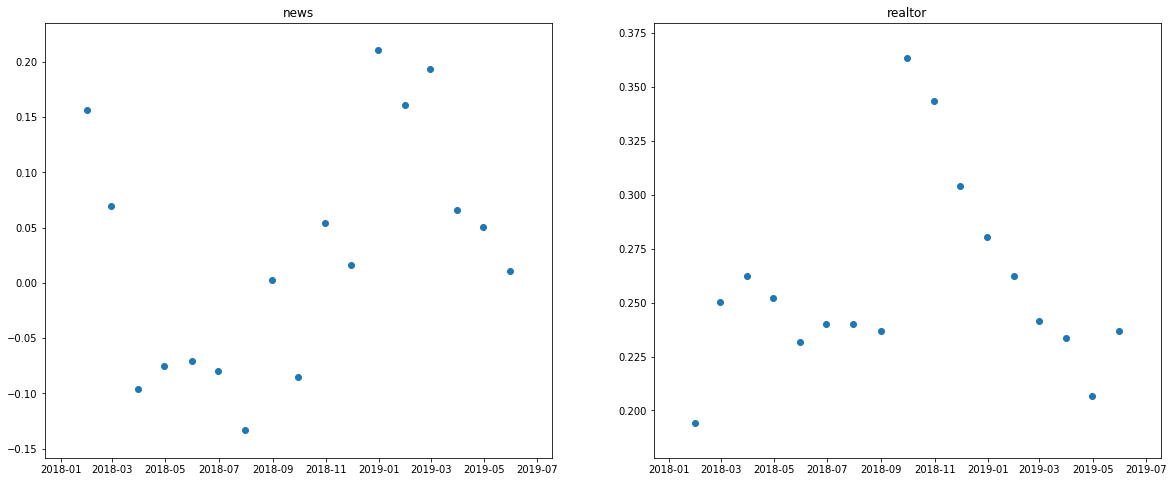

In [29]:
trendfig = plt.figure(figsize=(20,8))
fn = trendfig.add_subplot(121)
fn = sent_trend(news_recent)
fr = trendfig.add_subplot(122)
fr = sent_trend(realtor_recent)
axes = trendfig.get_axes()
axes[0].set_title('news')
axes[1].set_title('realtor')
plt.show()

In [30]:
def sent_ingroup(df):
    groupby_author = df.groupby('author').mean().reset_index().sort_values('sentiment')
#     f = groupby_author.plot(x='author',kind='barh', figsize = (8,6))
    f = plt.barh(groupby_author['author'], groupby_author['sentiment'])
    return f

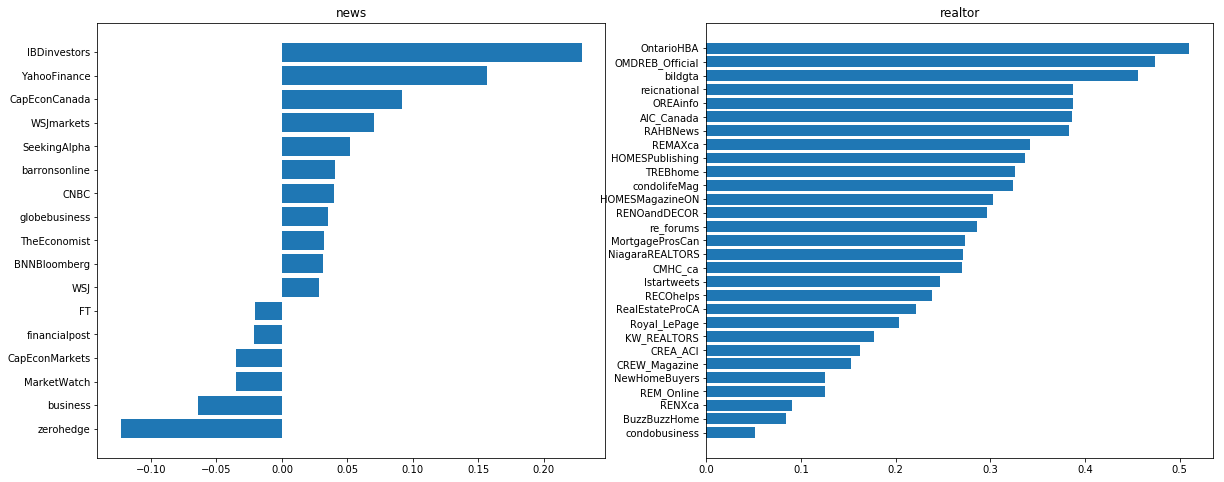

In [31]:
groupfig = plt.figure(figsize=(20,8))
fn = groupfig.add_subplot(121)
fn = sent_ingroup(news_recent)
fr = groupfig.add_subplot(122)
fr = sent_ingroup(realtor_recent)
axes = groupfig.get_axes()
axes[0].set_title('news')
axes[1].set_title('realtor')
plt.show()

## Price

In [32]:
df_pg = df_p.groupby(by=['city','proptype']).median().reset_index()

In [33]:
df_pg.columns = ['city','proptype','median_ask']

In [34]:
df_ppivot = df_pg.pivot(index='proptype',columns='city',values='median_ask')
df_ppivot

city,Aurora,Burlington,Hamilton,Markham,Milton,Mississauga,Newmarket,Oakville,Oshawa,Pickering,Richmond Hill,Toronto,Vaughan
proptype,,,,,,,,,,,,,
Apartment,"687,000","410,950","375,000","549,900",nan,"464,950",nan,"594,900",nan,nan,"515,400","624,500","559,500"
Bungalow,"2,190,000","897,000","494,350","1,188,999","1,199,750","1,012,400","799,000","1,099,000","554,900","2,020,000","1,253,800","850,000","1,514,900"
Detached,"1,158,000","979,500","562,000","1,339,400","877,950","1,267,500","876,950","1,414,450","619,900","894,450","1,459,444","1,293,000","1,399,450"
Loft,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"796,000",nan
Semi-Detached,nan,nan,"449,450","993,950",nan,"772,450",nan,nan,"624,450",nan,nan,"899,900","864,450"
Townhouse,"790,500","599,994","517,450","799,000","599,950","666,950","722,445","789,000","459,450","519,939","876,400","704,500","859,000"


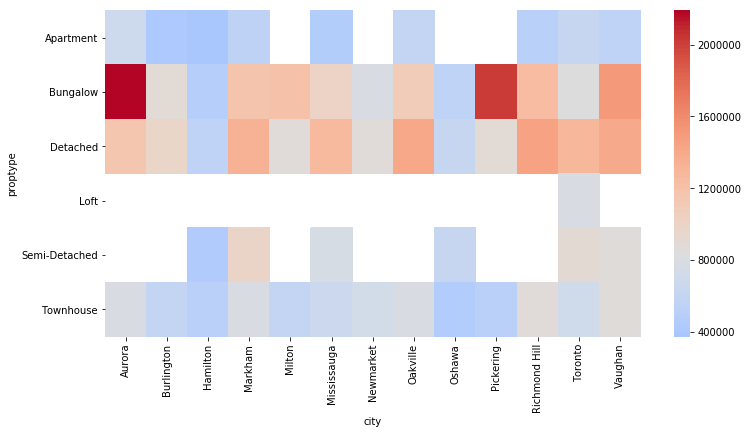

In [35]:
fig, ax = plt.subplots(figsize=(12,6))
sns_plot=sns.heatmap(data=df_ppivot,cmap="coolwarm",center=df_ppivot.mean(axis=1).mean())

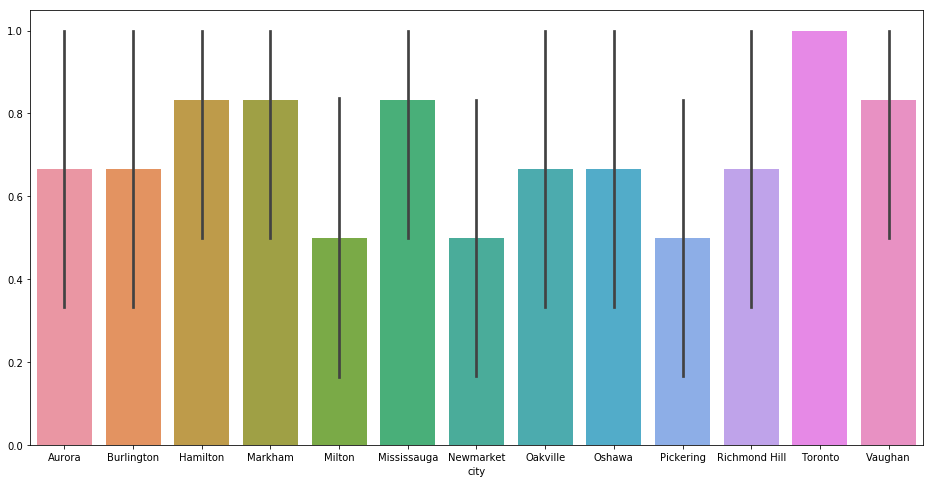

In [36]:
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data= df_ppivot.notnull())